In [105]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [106]:
import numpy as np
import pandas as pd

In [107]:
import datetime as dt
import time

# Reflect Tables into SQLAlchemy ORM

In [108]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [109]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [110]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [111]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [112]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [113]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

**Design a query to retrieve the last 12 months of precipitation data and plot the results**

In [114]:
# Calculate the date 1 year ago from the last data point in the database

# Last data point
last_date_data = engine.execute('SELECT max(date) FROM measurement').first()
last_date_str = last_date_data[0]
last_date = dt.datetime.strptime(last_date_str, '%Y-%m-%d').date()

# 1 year ago from the last data point
yr_frm_last_date = last_date - dt.timedelta(days=365)
yr_frm_last_date_str = yr_frm_last_date.strftime('%Y-%m-%d')

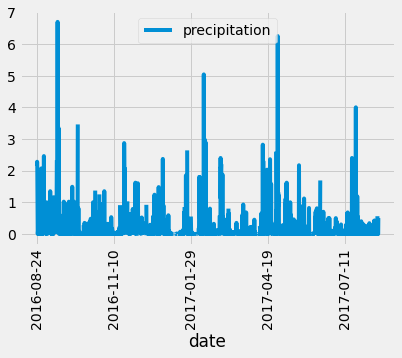

In [214]:
# Perform a query to retrieve the data and precipitation scores
prcp_12m = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date < last_date_str)\
                    .filter(Measurement.date > yr_frm_last_date_str).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_12m_df = pd.DataFrame(prcp_12m, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
prcp_12m_df_sorted =  prcp_12m_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
# prcp_12m_df_sorted.plot(kind='bar', rot=90, figsize=(23,7))

prcp_12m_df_sorted.plot(rot=90)
# Set x/y label, title
# plt.title(f'Precipitation\n({yr_frm_last_date_str} to {last_date_str})', fontweight = 'bold')
# plt.xlabel('Date', fontweight = 'bold')
# plt.ylabel('Inches', fontweight = 'bold')
# # plt.xticks(prcp_12m_df_sorted.index())
# plt.grid()
# plt.tight_layout()

# # Save bar graph to Images folder
# # pd_bar_prcp_12m.figure.savefig('Images/pd_bar_prcp_12m.png')

# # Present the bar chart
# plt.show()

# # To close pyplot
# plt.close()

In [210]:
prcp_12m_df_sorted

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-21,NaN
2017-08-21,0.02
2017-08-22,0.00


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data
SELECT measurement.date AS measurement_date, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date < ? AND measurement.date < ?]

In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
